# Лабораторная работа №4
# Решение ДУЧП гиперболического типа

## 1. 2D уравнение конвекции

Необходимо решить уравнение конвекции
$$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x} = 0,$$
при распространении косинусоидального импульса $$\phi(x) = cos(\frac{\pi x}{2}), x \in [0,10]$$

Также использовались граничные условия:
$$ \begin{cases}
 & \ U(0,t) = cos(- \frac{\pi x}{2}) \\ 
 & \ U(10,t) = cos(\frac{\pi x}{2})
\end{cases}$$

Цель:
* получить аналитическое решение
* явная двухслойная схема (FTCS метод)
* явная схема Лакса-Вендрофа,
* схема Рихтмайера (двухшаговый метод типа Лакса-Вендрофа)
* схема МакКормака (предиктор-корректорная схема типа Лакса-Вендрофа)
* противопотоковый метод первого порядка
* противопотоковый метод второго порядка

#### Необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

#### Начальные и граничные условия

In [2]:
u, length, time, columns = 1, 10., 10, 100


def initial(x: float) -> float:
    return math.cos(math.pi * x / 2)


def first_border(t: float) -> float:
    return math.cos(- math.pi * t / 2)


def second_border(t: float) -> float:
    return math.cos(math.pi * t / 2)

#### Функция отрисовки

In [6]:
def draw(dt1: float, u1: list) -> None:
    a, b = np.shape(u1)
    x = np.linspace(0, length, b)
    fig = plt.figure()
    
    ax1 = fig.add_subplot(221)
    ax1.grid()
    plt.plot(x, u1[int(0.1 / dt), :])

    ax2 = fig.add_subplot(222)
    ax2.grid()
    plt.plot(x, u1[int(0.5 / dt), :])

    ax3 = fig.add_subplot(223)
    ax3.grid()
    plt.plot(x, u1[int(1 / dt), :])

    ax4 = fig.add_subplot(224)
    ax4.grid()
    plt.plot(x, u1[int(5 / dt), :])
    
    plt.show()

### 1.1 Явная двухслойная схема
$$\frac{U_{i,j+1}-U_{i,j}}{\tau}+ u \frac{U_{i+1,j}-U_{i-1,j}}{2dx}=0$$

In [7]:
def explicity(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
    
    for i in range(lines + 1):
        T[i][0] = first_border(i * dt)
        T[i][columns] = second_border(i * dt)
    
    for k in range(lines):
        for j in range(1, columns):
            T[k + 1][j] = T[k][j] - c * (T[k][j + 1] - T[k][j - 1]) / 2
    return T, dt

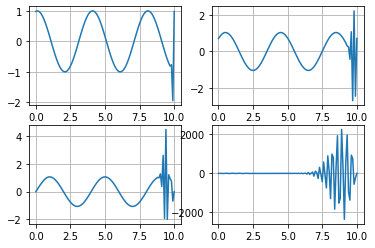

In [8]:
T, dt = explicity(c=0.5)
draw(dt, T)

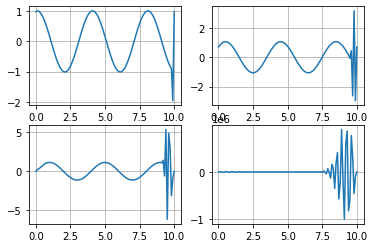

In [9]:
T, dt = explicity(c=1)
draw(dt, T)

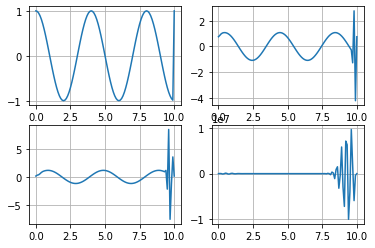

In [11]:
T, dt = explicity(c=1.5)
draw(dt, T)

Все графики представленные в этой работе построены при значениях времени 0.1, 0.5, 1 и 5 секундах, а также при значениях конвекционного числа 0.5, 1 и 1.5.

Как видно из представленных графиков выше, решение явной схемой расходится при любых значениях конвекционного числа.

### 1.2 Явная схема Лакса-Вендрофа
$$ U_{i,j+1}=U_{i,j}-u\left(\frac{U_{i+1,j}-U_{i-1,j}}{2h} \right)\tau +\frac{1}{2}u^{2}\left(\frac{U_{i+1,j}-2U_{i,j}+U_{i-1,j}}{h^{2}} \right) $$

In [13]:
def lax_wendroff(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
    
    for i in range(lines + 1):
        T[i][0] = first_border(i * dt)
        T[i][columns] = second_border(i * dt)
    
    for k in range(lines):
        for j in range(1, columns):
            T[k+1][j]=T[k][j]-c*(T[k][j+1]-T[k][j-1])/2+c**2*(T[k][j+1]-2*T[k][j]+T[k][j-1])/2
    return T, dt

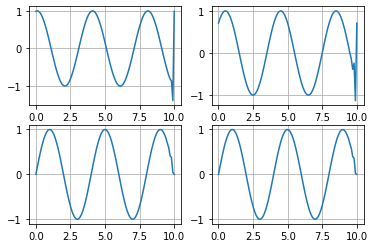

In [14]:
T, dt = lax_wendroff(c=0.5)
draw(dt, T)

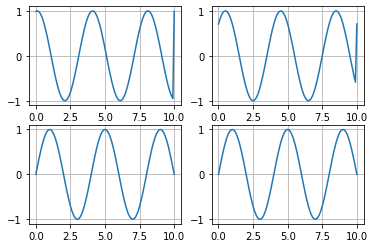

In [15]:
T, dt = lax_wendroff(c=1)
draw(dt, T)

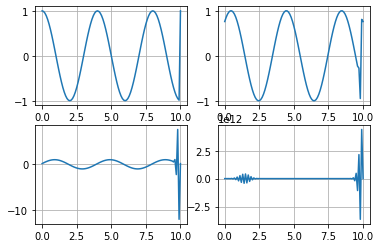

In [17]:
T, dt = lax_wendroff(c=1.5)
draw(dt, T)

При $c = 1$ явная схема Лакса-Вендрофа показывает наиболее точный результат. При значениях $с > 1$ решение расходится.

### 1.3 Cхема Рихтмайера (двухшаговый метод типа Лакса-Вендрофа)
$$U_{i,j+1} = \frac{1}{2}\left( U_{i+1,j}+U_{i-1,j}\right)-\frac{c}{2}\left(U_{i+1,j}-U_{i-1,j} \right)$$
$$U_{i,j+2} = U_{i,j}-c\left(U_{i+1,j+1}-U_{i-1,j+1} \right)$$

In [19]:
def lax_wendroff_2step(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
    
    for i in range(lines + 1):
        T[i][0] = first_border(i * dt)
        T[i][columns] = second_border(i * dt)
    
    for k in range(lines):
        prev_value = (T[k][1] + T[k][0]) / 2 - c * (T[k][1] - T[k][0]) / 2
        for j in range(1, columns):
            next_value = (T[k][j + 1] + T[k][j]) / 2 - c * (T[k][j + 1] - T[k][j]) / 2
            T[k + 1][j] = T[k][j] - c * (next_value - prev_value)
            prev_value = next_value
    return T, dt

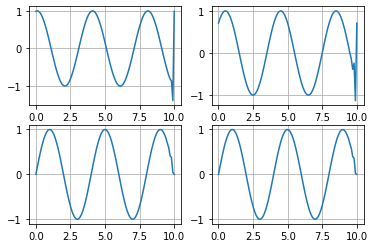

In [20]:
T, dt = lax_wendroff_2step(c=0.5)
draw(dt, T)

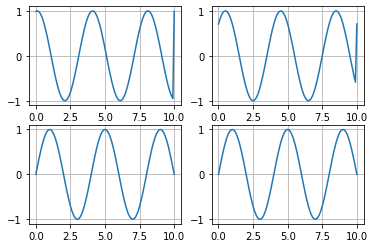

In [21]:
T, dt = lax_wendroff_2step(c=1)
draw(dt, T)

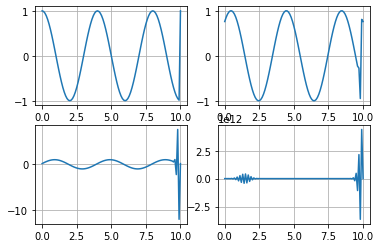

In [23]:
T, dt = lax_wendroff_2step(c=1.5)
draw(dt, T)

Точно такая же ситуация как и с одношаговым методом.

### 1.4 Cхема МакКормака (предиктор-корректорная схема типа Лакса-Вендрофа)
$$\bar{U}_{i,j+1}=U_{i,j}-c\left(U_{i+1,j} - U_{i,j} \right)$$
$$U_{i, j+1} =\frac{1}{2}\left[U_{i,j}+\bar{U}_{i, j+1}-c\left(\bar{U}_{i, j+1} - \bar{U}_{i-1, j+1}\right) \right]$$

In [25]:
def mc_cormack(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    T_up = np.zeros((lines + 1, columns + 1))
    T_down = np.zeros((lines + 1, columns + 1))
    
    for i in range(0, columns):
        T[0][i] = initial(i * dx)
    
    for i in range(lines + 1):
        T[i][0] = first_border(i * dt)
        T[i][columns] = second_border(i * dt)
        
    for k in range(lines):
        for j in range(1, columns):
            T_up[k + 1][j] = T[k][j] - c * (T[k][j + 1] - T[k][j])
            T[k + 1][j] = (T[k][j] + T_up[k + 1][j] - c * (T_up[k + 1][j] - T_up[k + 1][j - 1])) / 2
    return T, dt

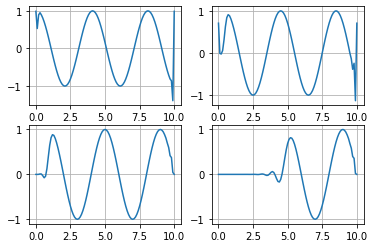

In [26]:
T, dt = mc_cormack(c=0.5)
draw(dt, T)

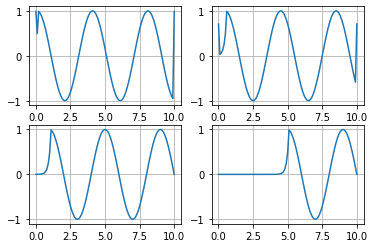

In [27]:
T, dt = mc_cormack(c=1)
draw(dt, T)

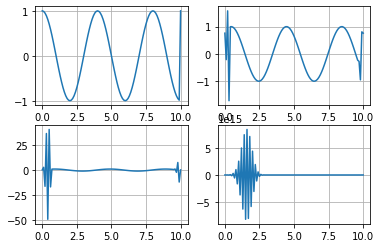

In [29]:
T, dt = mc_cormack(c=1.5)
draw(dt, T)

Cхема МакКормака лучше всего ведет себя при маленьких $c$. Что-то непонятное происходит при больших значениях времени, но на маленьких получается достаточно хорошее решение при $c <= 1$.

### 1.5 Противопотоковый метод первого порядка

$$\frac{U_{i,j+1}-U_{i,j}}{\tau}+u\frac{U_{i,j}-U_{i-1,j}}{h}=0$$

In [32]:
def upwind_step1(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
    
    for i in range(lines + 1):
        T[i][0] = first_border(i * dt)
        T[i][columns] = second_border(i * dt)
    
    for k in range(lines):
        for j in range(1, columns):
            T[k + 1][j] = T[k][j] - c * (T[k][j] - T[k][j - 1])
    return T, dt

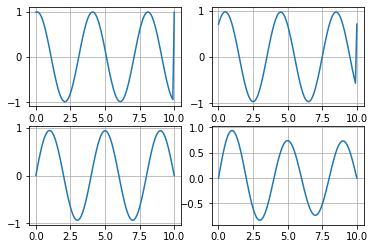

In [33]:
T, dt = upwind_step1(c=0.5)
draw(dt, T)

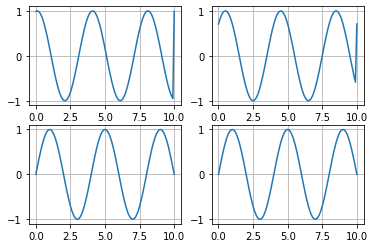

In [34]:
T, dt = upwind_step1(c=1)
draw(dt, T)

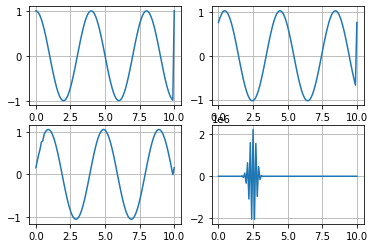

In [36]:
T, dt = upwind_step1(c=1.5)
draw(dt, T)

Противопотоковый метод первого порядка показывает лучшее решение при $c = 1$. При $c > 1$ начинает расходится на большом значении времени. При маленьких значениях $c$ происходит тоже самое. 

### 1.6 Противопотоковый метод первого порядка
$$U_{i,j+1} = U_{i,j}-c\left(U_{i,j}-U_{i-1,j} \right)-\frac{c(1-c)}{2}\left(U_{i,j} -2U_{i-1,j} +U_{i-2,j} \right)$$

In [50]:
def upwind_step2(c: float):
    dx = length / columns
    dt = dx * c / u
    lines = int(time / dt)
    T = np.zeros((lines + 1, columns + 1))
    
    for i in range(1, columns):
        T[0][i] = initial(i * dx)
    
    for i in range(lines + 1):
        T[i][0] = first_border(i * dt)
        T[i][columns] = second_border(i * dt)
        
    for i in range(1, lines + 1):
        T[i][1] = T[i - 1][1] - c * (T[i - 1][1] - T[i - 1][0])
    
    for k in range(lines):
        for j in range(2, columns):
            T[k+1][j] = T[k][j]-c*(T[k][j]-T[k][j-1])-c*(1-c)*(T[k][j]-2*T[k][j-1]+T[k][j-2])/2
    return T, dt

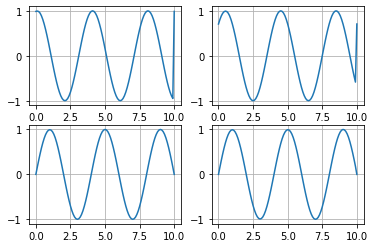

In [43]:
T, dt = upwind_step2(c=0.5)
draw(dt, T)

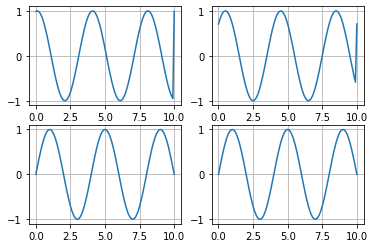

In [44]:
T, dt = upwind_step2(c=1)
draw(dt, T)

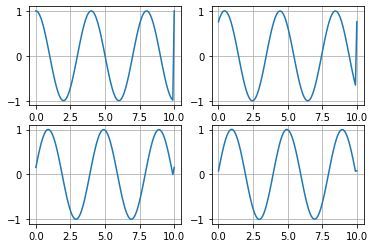

In [47]:
T, dt = upwind_step2(c=1.5)
draw(dt, T)

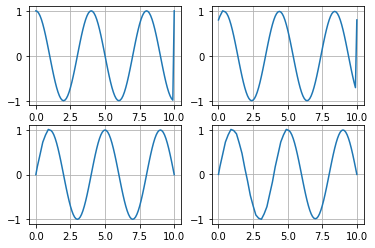

In [48]:
T, dt = upwind_step2(c=2)
draw(dt, T)

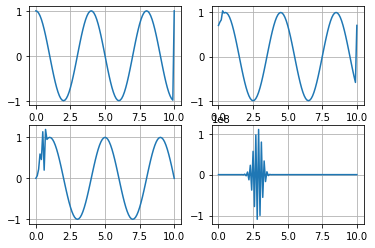

In [49]:
T, dt = upwind_step2(c=2.5)
draw(dt, T)

Данный метод показывает наилучшие результаты. Расходится при значениях $c > 2$.

## 2. Аналитическое решение

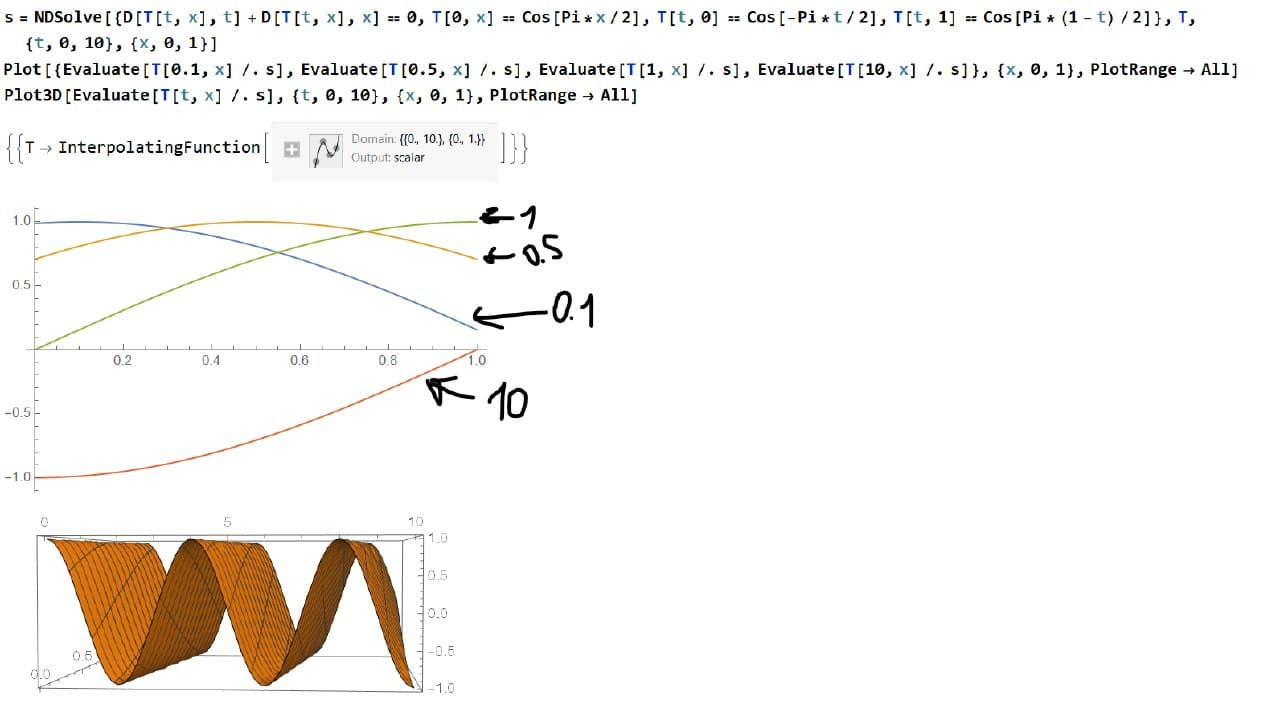